

```

```
# Modelo del Lenguaje con LSTM (pytorch)
```

```



Así como con las Vanilla-RNN, un modelo más complejos puede procesar los modelos del lenguaje. Una forma común de hacerlo es por medio de celdas LSTM. Aquí se presenta un modelo del lenguaje por medio de una RNN con LSTM.

En primer lugar definimos las funciones de indexado y obtención del vocabulario:

In [1]:
import torch
import torch.nn as nn
import numpy as np
from collections import defaultdict, Counter
from itertools import chain
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from operator import itemgetter

#Funcion que crea un vocabulario de palabras con un indice numerico
def vocab():
    vocab = defaultdict()
    vocab.default_factory = lambda: len(vocab)
    return vocab    

#Funcion que pasa la cadena de simbolos a una secuencia con indices numericos
def text2numba(corpus, vocab):
    for doc in corpus:
        yield [vocab[w] for w in doc.split()]

Ahora, a partir de un corpus. Obtenemos el vocabuclario en un diccionario con índices numéricos (idx) y convertimos las palabras en las sentencias en los índices correspondientes.

In [2]:
corpus = ['el perro come un hueso', 'un muchacho jugaba', 'el muchacho saltaba la cuerda',
          'un perro come croquetas', 'el perro come', 'el gato come croquetas', 'un gato come']

#Llamamos la funcion para crear el vocabulario
idx = vocab()
#Creamos el vocabulario y le asignamos un indice a cada simbolo segun su aparicion
cads_idx = list(text2numba(corpus,idx))

print(cads_idx)

[[0, 1, 2, 3, 4], [3, 5, 6], [0, 5, 7, 8, 9], [3, 1, 2, 10], [0, 1, 2], [0, 11, 2, 10], [3, 11, 2]]


De igual forma que en los modelos del lenguaje que hemos ya revisado, agregamos los símbolos de BOS y EOS.

In [3]:
#Indicamos las etiquetas a usar
EOS = '<EOS>'
BOS = '<BOS>'

#Cada etiqeuta se le asigna un indice numerico
BOS_IDX = max(idx.values())+2
EOS_IDX = max(idx.values())+1

#Se agregan estas etiqeutas al vocabulario
idx[EOS] = EOS_IDX
idx[BOS] = BOS_IDX

#A cada cadena se le agrega la etiqueta BOS al inicio y EOS al final
cadenas = [[BOS_IDX] + cad + [EOS_IDX] for cad in cads_idx]

Finalmente, obtenemos las instancias de entrenamiento. La idea es predecir la palabra subsecuente en la cadena; por tanto, nuestras instancias de entrenamiento están conformados por:

1) El input, $x$, conformado por la cadena (con el símbolo BOS, pero no el EOS):
$$x = (<BOS>, w_1,...,w_T)$$
2) El target, $y$, conformado por los elementos subsecuentes en la cadena (con el EOS, pero sin el BOS):
$$y = (w_1,...,w_T,<EOS>)$$
Así, el objetivo de la red es que, dado una entrada $x$, se obtenga un target $y$; en otras palabras, para cada palabra, se busca predecir la palabra subsecuente:

In [4]:
#Se crean las cadenas de ejemplos
ex = [(cad[:-1],cad[1:]) for cad in cadenas]

print(ex)

[([13, 0, 1, 2, 3, 4], [0, 1, 2, 3, 4, 12]), ([13, 3, 5, 6], [3, 5, 6, 12]), ([13, 0, 5, 7, 8, 9], [0, 5, 7, 8, 9, 12]), ([13, 3, 1, 2, 10], [3, 1, 2, 10, 12]), ([13, 0, 1, 2], [0, 1, 2, 12]), ([13, 0, 11, 2, 10], [0, 11, 2, 10, 12]), ([13, 3, 11, 2], [3, 11, 2, 12])]


Ahora, definimos las dimensiones con las que vamos a trabajar. 

1) $N$ es el tamaño del vocabulario. Nuestra red tendrá una entrada de tamaño $N$ (equivalente a un one-hot)
2) La dimensión de los embeddings (dim)
3) La dimensión de las celdas del LSTM (dim_h)
4) La dimensión de una capa oculta extra, (dim_h2)
5) La dimensión de salida (dim_out), que será también del tamaño del vocabulario.

In [86]:
#Se obtiene la longitud del alfabeto
N = len(idx)

#Se definen las dimensiones en todas las capas
dim_in = N
dim = 200
dim_h = 100
#dim_h2 = 100
dim_out = N

Ahora definimos la arquitectura de nuestra red. Esta se conformará de la siguiente forma:

1) Una capa de embedding (emb): si $C$ es la matriz de embedding y $x^{(t)}$ el one-hot de entrada en el estado $t$, entonces:
$$emb^{(t)} = Cx^{(t)}$$
2) Una celda de LSTM: 
 $$h^{(t)},c^{(t)} = biLSTM(emb^{(t)}, h^{(t-1)})$$
 3) Una capa oculta con tangente hiperbólica:
 $$h_{tanh} = \tanh(W_hh^{(t)} + b_h)$$
 4) Una capa de salida con Softmax:
 $$\phi(x^{(t)}) = Softmax(W_{out}h_{tanh}+b_{out})$$

In [87]:
#Capa de embedding
emb = nn.Embedding(dim_in,dim)

In [88]:
#Capa de LSTM (se toma bidireccional)
lstm = nn.LSTM(dim,dim_h,bidirectional=True)

In [89]:
#Capa oculta con tanh y capa de salida con Softmax (2*dim_h por que concatena forward y backward)
#forward = nn.Sequential(nn.Linear(2*dim_h,dim_h2), nn.Tanh(), nn.Linear(dim_h2,dim_out), nn.Softmax(dim=2))
forward = nn.Sequential(nn.Linear(2*dim_h,dim_out), nn.Softmax(dim=2))

Ahora definimos la función de pérdida y la forma en que optimizaremos nuestros parámetros:
Para la función de pérdida usamos la entropía curzada y para actualizar los parámetros el Gradientes Descendiente Estocástico:

In [90]:
#La función de riesgo es la entropía cruzada
criterion = torch.nn.CrossEntropyLoss()

#Los parametros que se van a actualizar
optimizer = torch.optim.SGD(list(emb.parameters()) + list(lstm.parameters()) + list(forward.parameters()), lr=0.1)

Finalmente entrenamos, para esto corremos la red por cada ejemplo dado un número de iteraciones y aplicamos el método de backpropagation que nos aporta pytroch:

In [91]:
%%time

#Numero de iteraciones
its = 100
#Se entrena el modelo
for epoch in range(its):
	for sent,pred in ex:
		#FORWARD
		#Se pasa a formato torch
		sent = torch.tensor(sent)
		#Embedding
		emb_x = emb(sent)
		#Resize del embedding (se agrega dimension de length_seq)
		emb_x = emb_x.unsqueeze(1)
		#LSTM
		out, dat = lstm(emb_x)
		#Capa de salida sobre out de LSTM
		y_pred = forward(out)
		#Se acomoda la salida para que la tome el loss
		y_pred = y_pred.transpose(1, 2)
		
		#BACKWARD
		#Resize de las variables esperadas (se agrega dimension de length_seq)
		pred = (torch.tensor(pred)).unsqueeze(1)

		#Se calcula el eror
		loss = criterion(y_pred, pred)
		#zero grad
		optimizer.zero_grad()
		#Backprop
		loss.backward()
		#Se actualizan los parametros
		optimizer.step()

CPU times: user 20.6 s, sys: 55.7 ms, total: 20.7 s
Wall time: 3.46 s


Para probar el método definimos una función forward (predict) que nos dará la salida dado una cadena de entrada.

In [92]:
def predict(X):
	#Se transforma la cadena en indices numericos
	sent = torch.tensor(list(text2numba([X],idx))[0])
	#Embedding
	emb_x = emb(sent)
	#Resize embedding
	emb_x = emb_x.unsqueeze(1)
	#LSTM
	out, (hn,cn) = lstm(emb_x)
	#Capa de salida
	y_pred = forward(out)
	#Resize salida
	y_pred = y_pred.transpose(1, 2)

	return y_pred

Podemos usar esta red, por ejemplo, para ver las probabilidades de transición dada una palabra.

In [93]:
probs = predict('<BOS>')[-1]

for word in idx.keys():
    if word != '<BOS>':
        print(word,float(probs[idx[word]]))

el 0.4930282235145569
perro 0.003990109544247389
come 0.001234166556969285
un 0.47753041982650757
hueso 0.002064767759293318
muchacho 0.005493715405464172
jugaba 0.00238015060313046
saltaba 0.0023001395165920258
la 0.0017211795784533024
cuerda 0.0021257419139146805
croquetas 0.002224709838628769
gato 0.0026704538613557816
<EOS> 0.0016198434168472886


También podemos predecir la palabra subsecuente más probable:

In [94]:
string = '<BOS> el perro'
probs = predict(string)[-1]
pred_word = list(idx.keys())[int(probs.argmax())]

print(string+' '+pred_word)

<BOS> el perro come


### Ploteo de embeddings

In [95]:
#Funcion para plotear los datos con labels
def plot_words(Z,ids):
    #Reduce la dimensionalidad a 2
    Z = PCA(2).fit_transform(Z)
    
    #Plotea con la marcas (marker) y el color indicado (c)
    r=0
    plt.scatter(Z[:,0],Z[:,1], marker='o', c='blue')
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1
    #plt.show()

#Ordena las etiquetas para que coincidan con los vectores-renglón de la matriz de embedding
label = [w[0] for w in sorted(idx.items(), key=itemgetter(1))]

In [96]:
C = list(emb.parameters())[0].detach().numpy()

In [97]:
labels = [pair[0] for pair in sorted(idx.items(), key=itemgetter(1))]

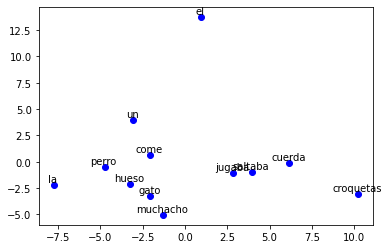

In [98]:
plot_words(C[:-2], labels)

#### Cálculo de similitud

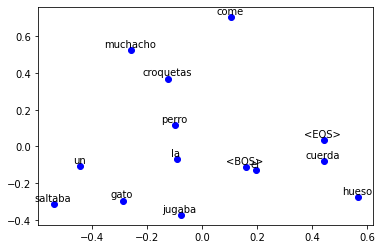

In [54]:
C_norm = (C.T/np.array([np.linalg.norm(v) for v in C])).T
plot_words(C_norm,labels)

In [55]:
targ_w = C_norm[idx['gato']]

for w, k in idx.items():
    cos = np.dot(targ_w, C_norm[k])
    dist = np.linalg.norm(targ_w -C_norm[k])
    print(w, cos, dist)

el 0.02993743 1.3928838
perro 0.034585252 1.3895429
come -0.02957018 1.4349705
un 0.05405872 1.3754572
hueso -0.021648997 1.4294398
muchacho -0.08242198 1.4713408
jugaba -0.01716005 1.426296
saltaba 0.10218584 1.3400106
la 0.07756304 1.3582615
cuerda -0.07495596 1.4662578
croquetas -0.082485065 1.4713838
gato 1.0 0.0
<EOS> -0.03807128 1.4408826
<BOS> -0.07871746 1.4688209


## ELMo

El modelo de ELMo (Peters et al., 2018) propone representar las palabras en contextos, esto es, las representaciones vectoriales son funciones de la sentencia de entrada. Para hacer esto, toma en cuenta las celdas de la capa de biLSTM $h^{(t)} = [\overrightarrow{h^{(t)}}; \overleftarrow{h^{(t)}}]$ en el estado $t$ y los combinan con los embeddings obtenidos. Para esto, necesitamos definir una función forward que nos permita recuperar estos valores:

In [56]:
def predict(X):
    #Separa la sentencia
    sent_idx = list(text2numba([X],idx))[0]
    #Longitud de la sentencia
    m = len(sent_idx)
    #Se transforma la cadena en indices numericos
    sent = torch.tensor(sent_idx)
    #Embedding
    emb_x = emb(sent)
    #Resize embedding
    emb_x = emb_x.unsqueeze(1)
    #Embeddings resahpeados
    h0 = emb_x.detach().numpy().reshape(m,dim)
    #LSTM
    out, (hn,cn) = lstm(emb_x)
    #Capas biLSTM
    h1 = out.detach().numpy().reshape(m,2*dim_h)
    #Capa de salida
    y_pred = forward(out)
    #Resize salida
    y_pred = y_pred.transpose(1, 2)

    return y_pred, (h0,h1)

Dada una cadena de longitud $m$, entonces se computan las $m$ celdas biLSTM $h^{(t)}$. El modelo de ELMo determina una representación contextualizada por medio de una combinación lineal. Dado que sólo tenemos dos vectores (el de embedding $x^{(t)}$ y el de biLSTM $h^{(t)}$) esta combinación es de la forma:

$$ELMo(w_t) = \gamma(s_1 x^{(t)} + s_2 h^{(t)})$$

La representación de la palabra $w_t$ en contexto es el vector resultante. El valor de $\gamma$ escala los vectores, en este caso, tomaremos $\gamma=1$. Los valores $s_i$ son pesos (generalmente obtenidos por una función softmax), que en este caso tomarán cada uno un valor igual a 0.5 para simplificar

In [67]:
#Cadena de entrada
input_sent1 = 'el perro come un hueso'
#Obtención de los valores
probs, (x,h) = predict(input_sent1)

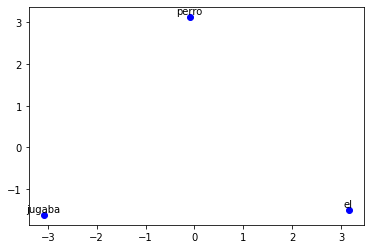

In [70]:
s1, s2 = 0.2, 0.8
plot_words(s1*x+s2*h, input_sent1.split())
plt.show()

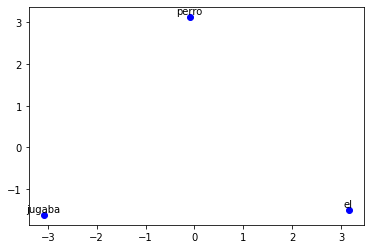

In [71]:
#Cadena de entrada
input_sent1 = 'el perro jugaba'
#Obtención de los valores
probs, (x,h) = predict(input_sent1)
s1, s2 = 0.2, 0.8
plot_words(s1*x+s2*h, input_sent1.split())
plt.show()

En el caso de ELMo, los vectores están siempre contextualizados. Como puede verse, el resultado es diferente de los embeddings obtenidos en la capa correspondiente; mientras que los embeddings son independientes del contexto, los vectores de ELMo no lo son.